<a href="https://colab.research.google.com/github/jihyunjeongme/data-science/blob/master/7%EC%9E%A5_%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%EB%8B%A4%EB%A4%84%EB%B3%B4%EC%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 시계열 분석
- 통계적으로 어렵고 복잡한 작업
- 원 데이터의 안정성을 판정하고, 안정한 형태로 변환하고, 예측 모델을 선정하고 검증하는 과정이 통계학의 깊은 지식을 요구
- 그러나 통계 전문가에게 맡기기 전에 간단한 데이터 예측하는 가벼운 느낌으로 여기서 함
### fbprophet
- 페이스 북에서 만든 모듈
- 여기서는 fbprophet을 통해서 시계열 예측을 수행

In [17]:

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
cd /content/gdrive/My Drive/Colab Notebooks/datascience/7. time_series

/content/gdrive/My Drive/Colab Notebooks/datascience/7. time_series


In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet
from datetime import datetime

In [20]:
# 한글폰트 설정

import matplotlib.font_manager as fm  # 폰트 관련 용도
%matplotlib inline


# 나눔 고딕 인스톨

!apt-get update -qq
!apt-get install fonts-nanum* -qq

# 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
path = '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf'  
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

# 우선 fm._rebuild() 를 해주고
# fm._rebuild() 를 해줘야 system 에 추가 설치된 폰트를 matplotilb.font_manager 가 알아차리는 것으로 보인다.
fm._rebuild()

NanumMyeongjo


In [21]:
pinkwink_web = pd.read_csv('08. PinkWink Web Traffic.csv', encoding='utf-8'
                          , thousands=',' , names = ['date','hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()                           

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


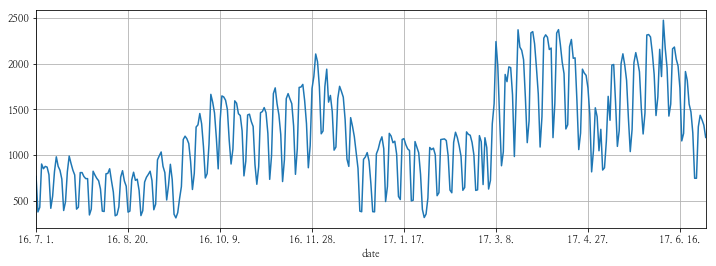

In [22]:
# 2016년 7월 1일 ~ 2017년 6월 16일까지 유입량
pinkwink_web['hit'].plot(figsize=(12,4), grid=True)

In [0]:
time = np.arange(0, len(pinkwink_web))
traffic = pinkwink_web['hit'].values

fx = np.linspace(0, time[-1], 1000)

In [0]:
# 먼저 시간 축(time)을 만들고 웹 트래픽의 자료를 traffic 변수에 저장합니다.
# 코드 [11]의 결과로 보이는 그래프를 설명한 간단한 함수를 찾으려고 함.
# 모델을 1차, 2차,3차,15차 다항식으로 표현, 그 결과를 확인

def error(f, x, y):
  return np.sqrt(np.mean((f(x)-y)**2))


In [25]:
# 어떤 데이터를 어떤 모델로 표현하려고 하면 그 모델의 적합성을 확인 하는 과정 필요
# 참 값과 비교해서 에러(error)를 계산 
# 코드 [13]에서 에러 함수를 정의

fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

430.8597308110963
430.6284101894695
429.53280466762925
330.47773021321143


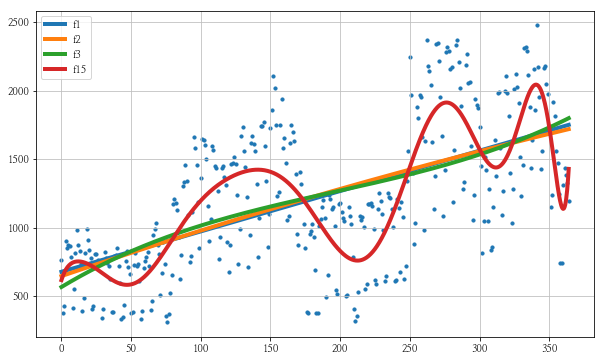

In [26]:
# polyfit과 poly1d를 사용해서 함수로 표현
# 그렇게 해서 1차, 2차, 3차 15차 함수로 표현 후 확인
# 1,2,3차는 에러가 비슷

plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')

plt.legend(loc=2)
plt.show()

In [0]:
# 1,2,3차가 정의된 함수에서 에러를 확인해 보니 에러가 왜 큰 차이가 없는지 확인 가능
# 2,3차로 표현하려면 그냥 1차로 표현하는 것이 나아보임

# 15차 함수를 사용해서 표현하는 것은 과적합(over-fitting)일 수 있음.

## Prophet 모듈을 이용한 forecast 예측
- Prophet 모듈은 사용법이 아주 간단함.

In [0]:
# pinkwink_web 변수에서 날짜(index)와 방문수(hit)만 따로 저장

# pandas가 지원하는 to_datetime 함수를 이용해서 날짜라고 선언
# Prophet 함수를 사용해서 주기성 설정

df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format="%y. %m. %d.")

m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(df);

In [30]:
df.head()

,date,ds,y
0,16. 7. 1.,2016-07-01,766.0
1,16. 7. 2.,2016-07-02,377.0
2,16. 7. 3.,2016-07-03,427.0
3,16. 7. 4.,2016-07-04,902.0
4,16. 7. 5.,2016-07-05,850.0


In [0]:
del df['date']

In [32]:
# 이후 60일간의 데이터를 예측 하고 싶다면 make_future_dataframe을 명령

future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


In [33]:
# 그리고 예측한 데이터를 forecast 변수에 저장

forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,908.795521,688.564866,1127.676364
421,2017-08-26,493.698181,284.238658,700.261419
422,2017-08-27,626.306553,417.555031,828.353795
423,2017-08-28,1179.043997,971.541734,1394.076818
424,2017-08-29,1214.996738,1011.093590,1425.103468


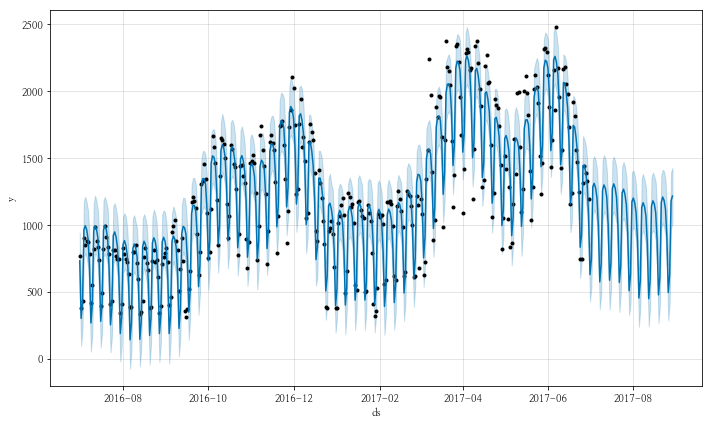

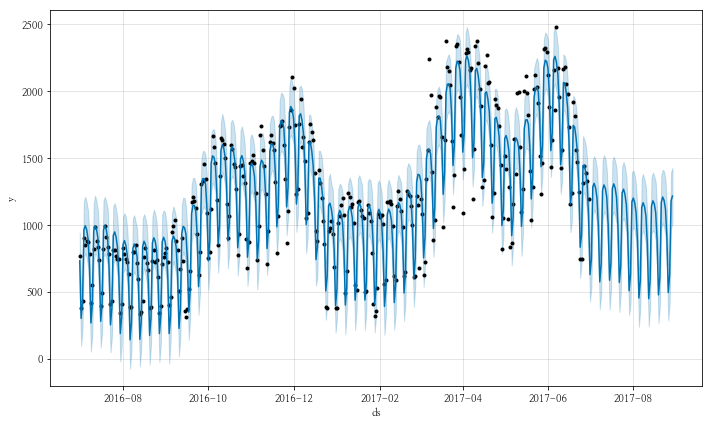

In [34]:
m.plot(forecast)

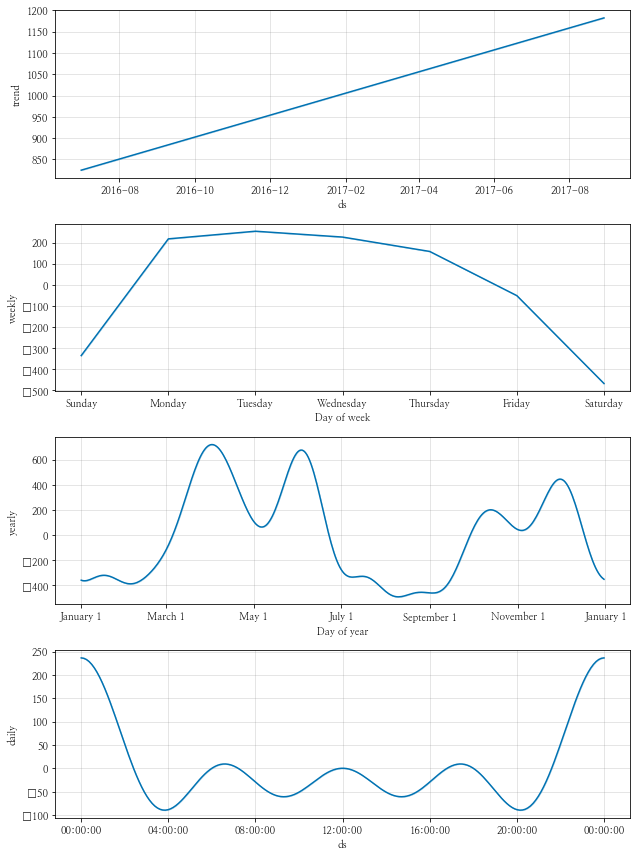

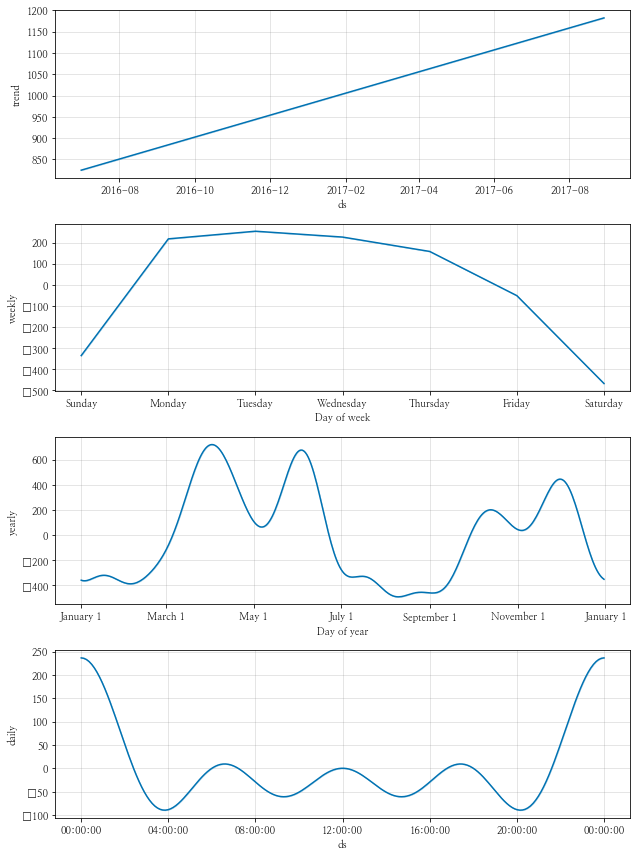

In [35]:
# 2017년 6월 말까지의 데이터 이후 약 2개월(60일)의 예측 결과가 코드 [34]의 결과에 나타나 있습니다.
# 단순히 다항식으로 경향을 파악하는 것보다는 뭔가 나아 보입니다.

m.plot_components(forecast)

In [0]:
# 그리고 components 명령으로 몇몇 재미난 결과를 얻을 수 있습니다.

# 전체적인 경향은 직선
# 이러한 과정을 Seasonal 시계열 데이터 분석(Seasonal Time Series Data Analysis)이라고 합니다.

## Seasonal 시계열 분석으로 주식 데이터 분석하기
- Pandas는 구글이 제공하는 주가 정보를 받아 올 수 있는 기능이 있습니다.
- 바로 DataReader 함수 입니다.
- 종목 코드를 알면 한국 KOSPI 주가정보도 받아 올 수 있습니다.

In [55]:
# 터미널에서 pip install fix_yahoo_finance로 fix_yahoo_finance를 설치하시고 아래와 같이 코드에서 사용하시면 됩니다.

!pip install fix_yahoo_finance
!pip3 install pandas_datareader


from pandas_datareader import data
import fix_yahoo_finance as yf
yf.pdr_override()

start_date = '2017-01-01' 
end_date = '2019-08-25' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)

KIA.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-05,41500.0,41950.0,41000.0,41650.0,41650.0,1528001
2019-06-07,42450.0,42950.0,40750.0,41150.0,41150.0,1814285
2019-06-10,42950.0,43000.0,42250.0,43000.0,43000.0,1357541
2019-06-11,42850.0,43000.0,42150.0,42800.0,42800.0,1122282
2019-06-12,42800.0,43200.0,42600.0,42800.0,42800.0,836853


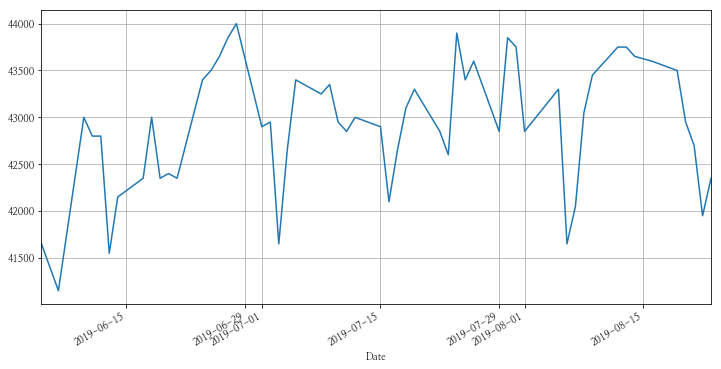

In [56]:
KIA['Close'].plot(figsize=(12,6),grid=True)